In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
import tensorflow as tf
import random

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

In [ ]:
def invert_images(images):
    return 1.0 - images

def add_noise(images, noise_level=0.3):
    noise = np.random.normal(loc=0.0, scale=noise_level, size=images.shape)
    noisy = images + noise
    return np.clip(noisy, 0., 1.)

def resize_images(images, target_size=(20, 20), original_size=(28, 28)):
    resized = np.array([
        img_to_array(array_to_img(img[..., np.newaxis]).resize(target_size)).squeeze()
        for img in images
    ])
    restored = np.array([
        img_to_array(array_to_img(img[..., np.newaxis]).resize(original_size)).squeeze()
        for img in resized
    ])
    return restored / 255.0

In [ ]:
datasets = {
    "original": (x_train, x_test),
    "inverted": (invert_images(x_train), invert_images(x_test)),
    "noisy": (add_noise(x_train), add_noise(x_test)),
    "resized": (resize_images(x_train * 255.0), resize_images(x_test * 255.0))
}


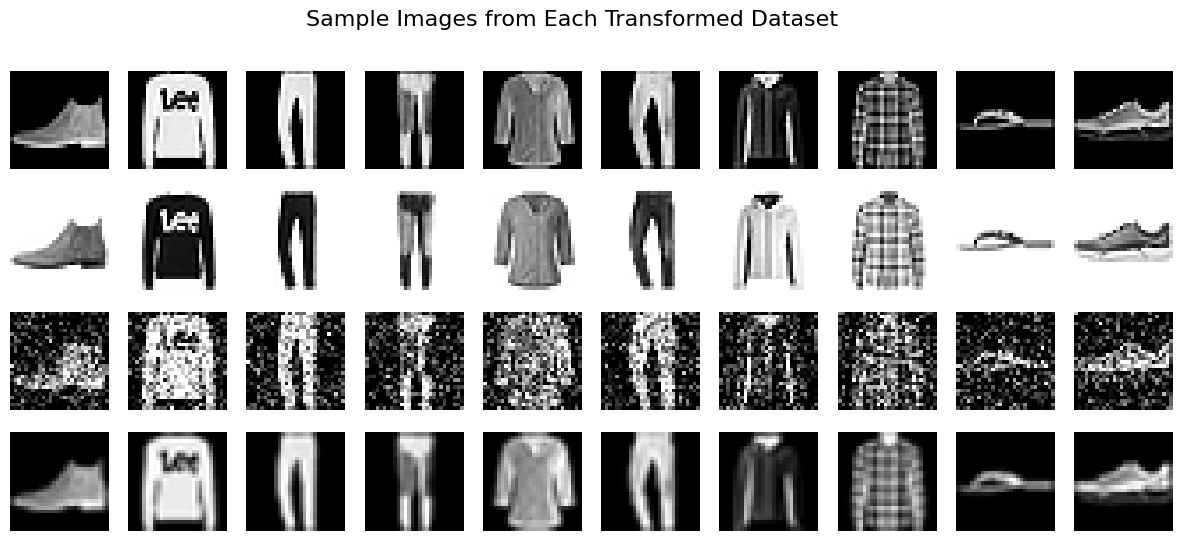

In [ ]:
plt.figure(figsize=(15, 6))
for idx, (key, (xtr, xte)) in enumerate(datasets.items()):
    for i in range(10):
        plt.subplot(4, 10, idx * 10 + i + 1)
        plt.imshow(xte[i], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.ylabel(key, fontsize=12)
plt.suptitle("Sample Images from Each Transformed Dataset", fontsize=16)
plt.show()

In [ ]:
def create_dnn_model():
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
history_dict = {}
results_dict = {}



Training on original dataset...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


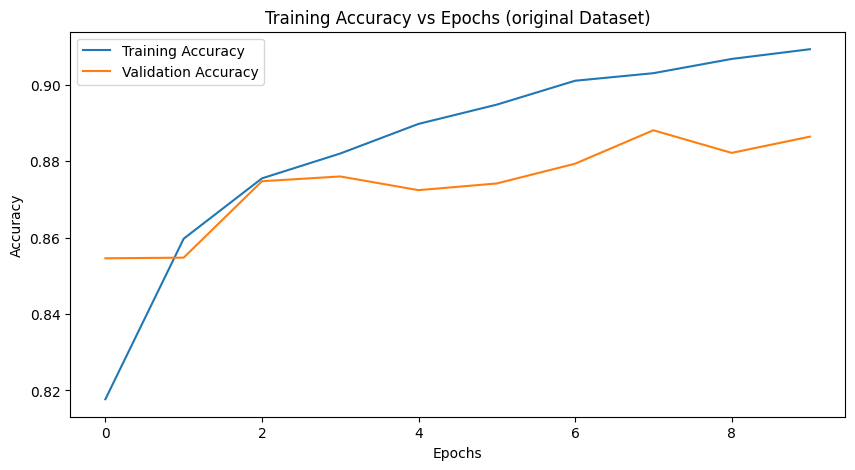

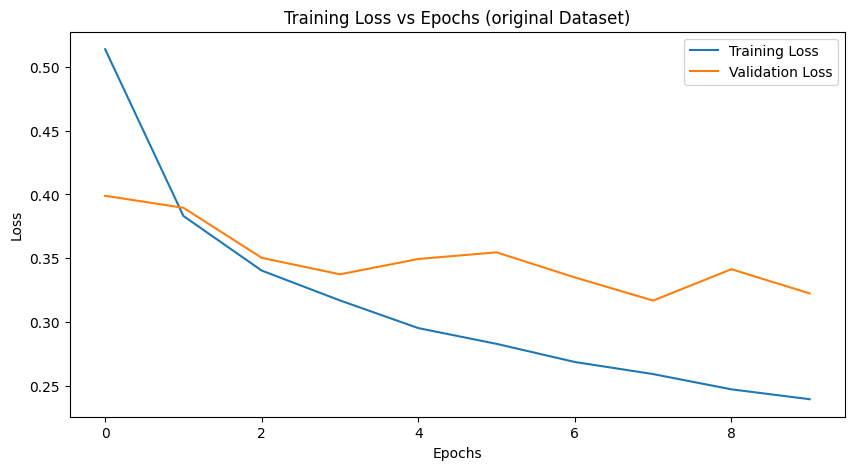


Training on inverted dataset...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


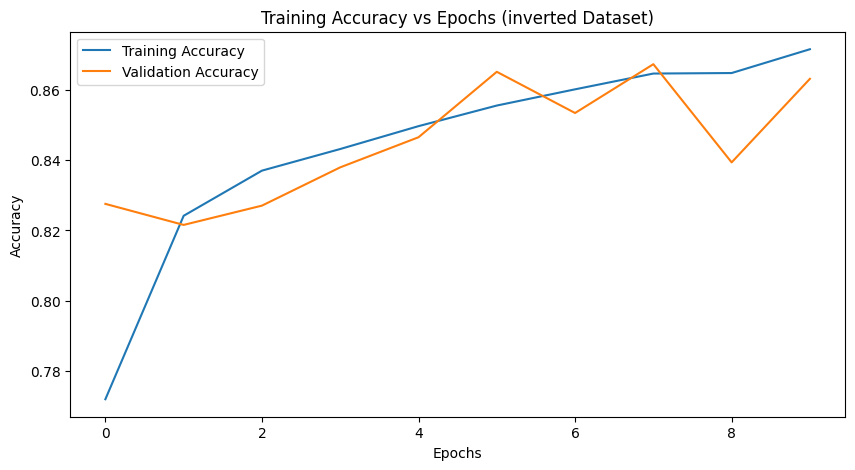

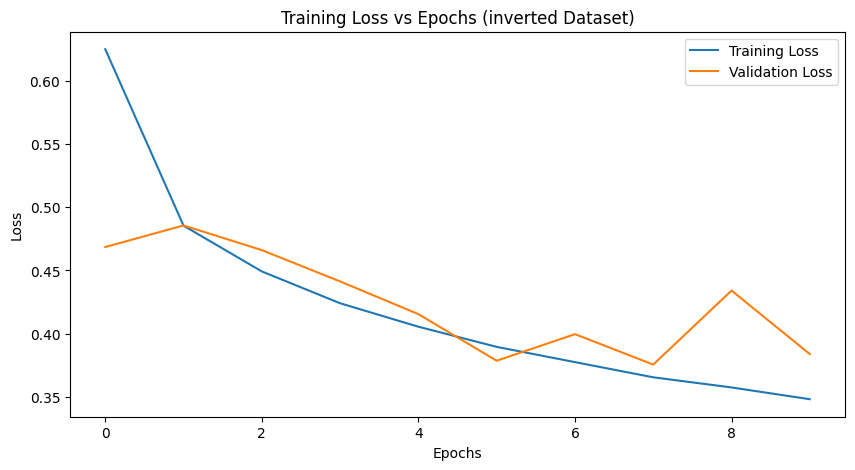


Training on noisy dataset...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


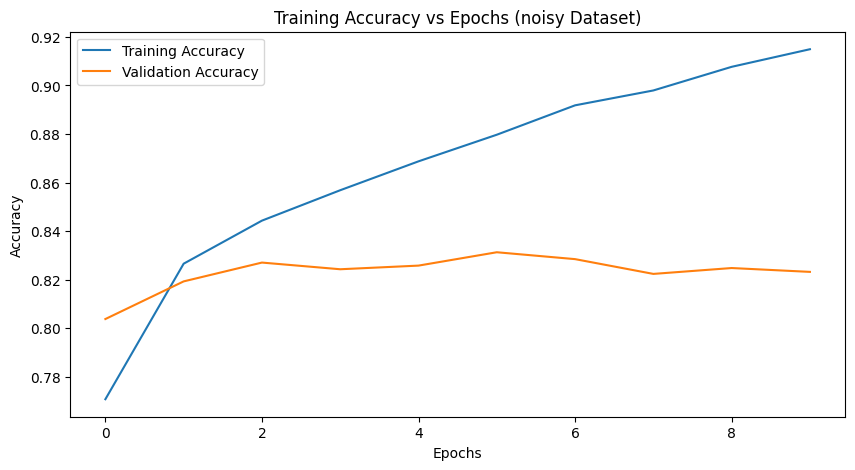

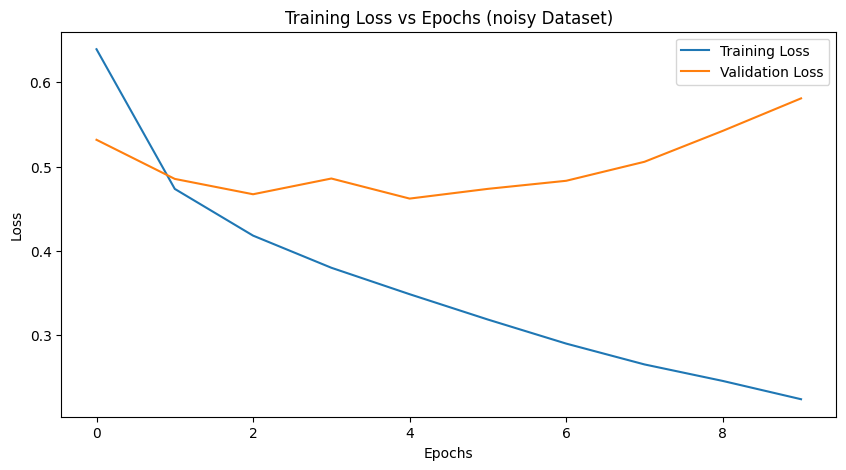


Training on resized dataset...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


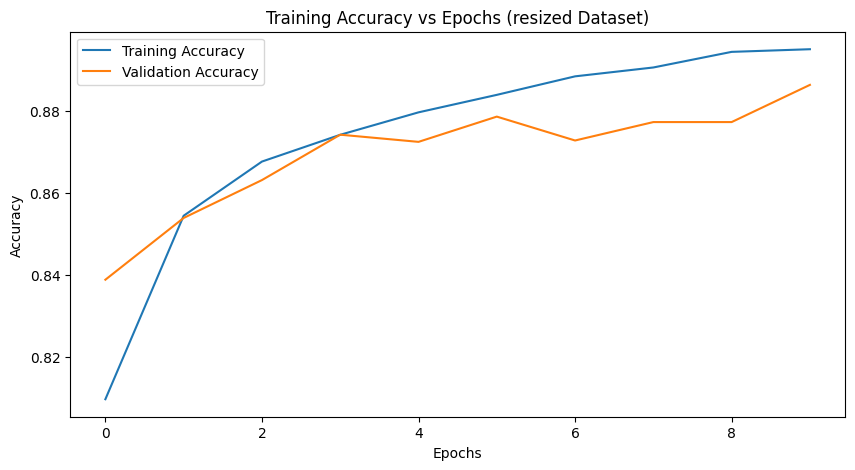

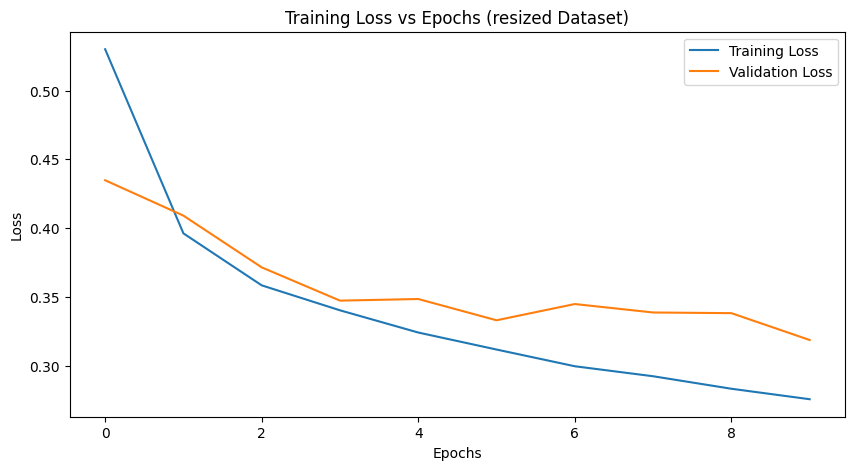

In [ ]:
import matplotlib.pyplot as plt

# History dictionary to store the results
history_dict = {}

for name, (xtr, xte) in datasets.items():
    print(f"\nTraining on {name} dataset...")
    model = create_dnn_model()
    history = model.fit(xtr, y_train_cat, validation_split=0.2, epochs=10, verbose=0)
    score = model.evaluate(xte, y_test_cat, verbose=0)
    preds = model.predict(xte)

    history_dict[name] = (model, history, preds)

    # Plot Training Accuracy vs Epochs
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"Training Accuracy vs Epochs ({name} Dataset)")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot Training Loss vs Epochs
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"Training Loss vs Epochs ({name} Dataset)")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


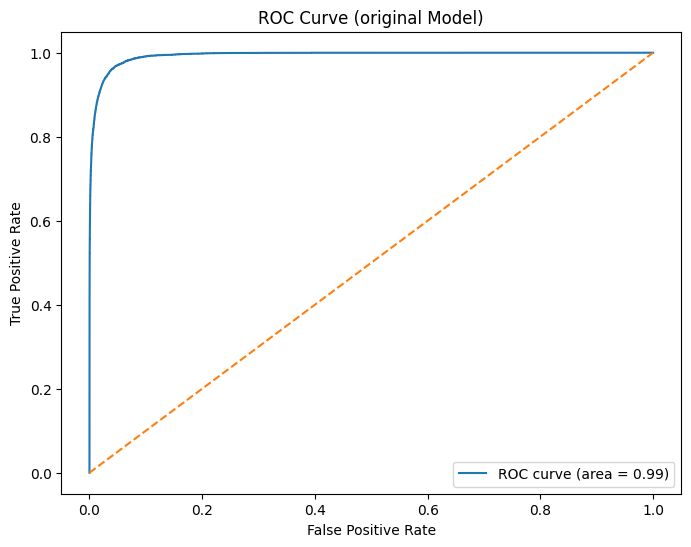

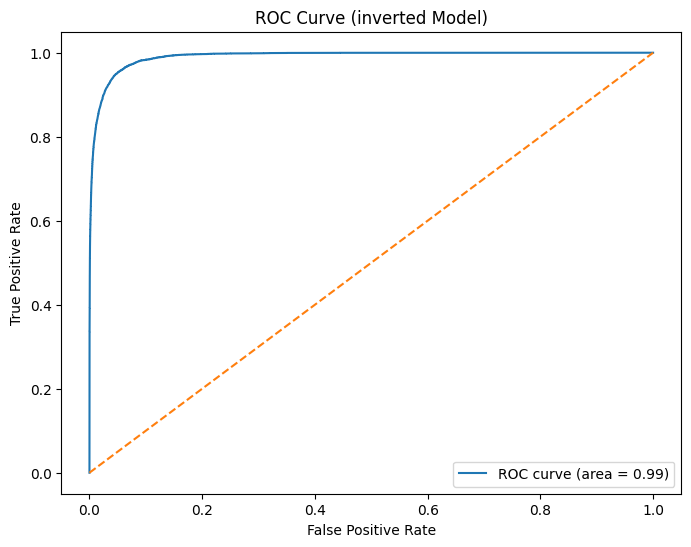

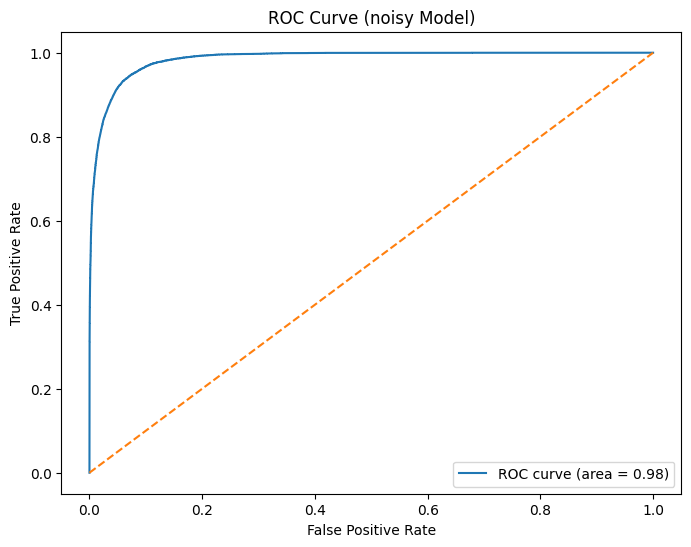

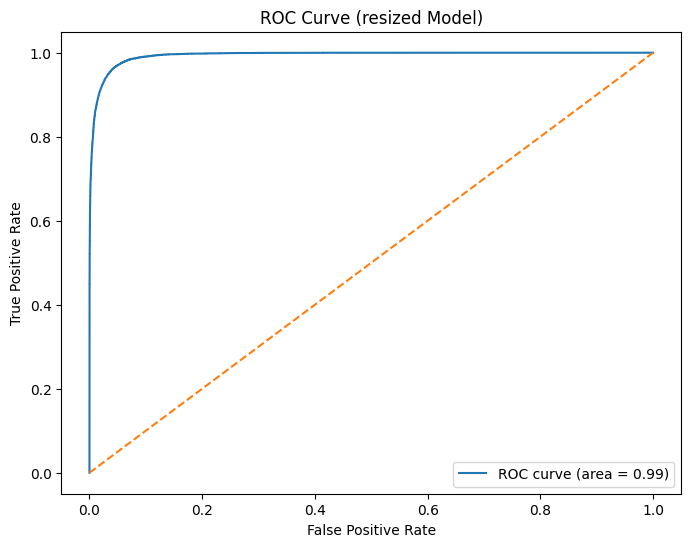

In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np

for name, (model, _, preds) in history_dict.items():
    fpr, tpr, _ = roc_curve(y_test_cat.ravel(), preds.ravel())
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curve ({name} Model)")
    plt.legend(loc='lower right')
    plt.show()


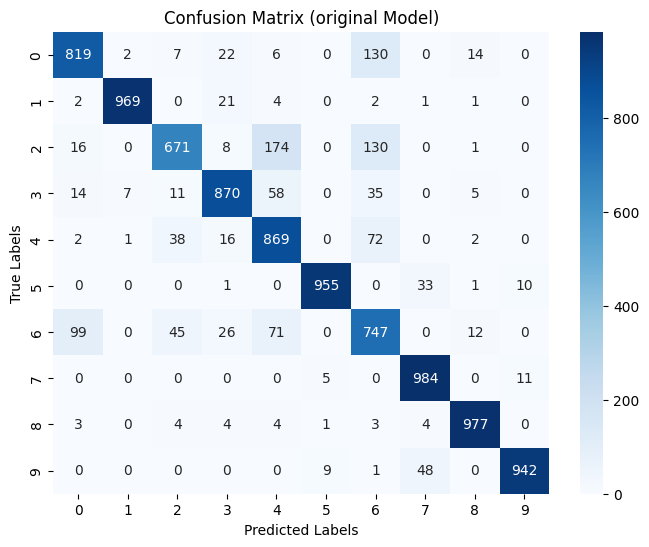

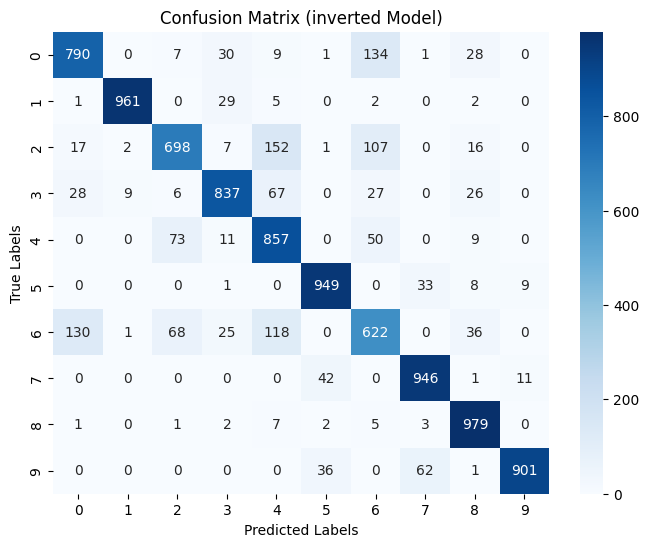

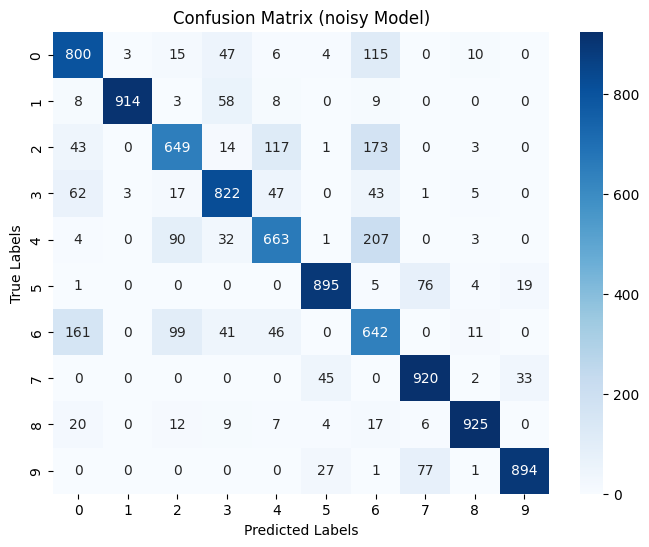

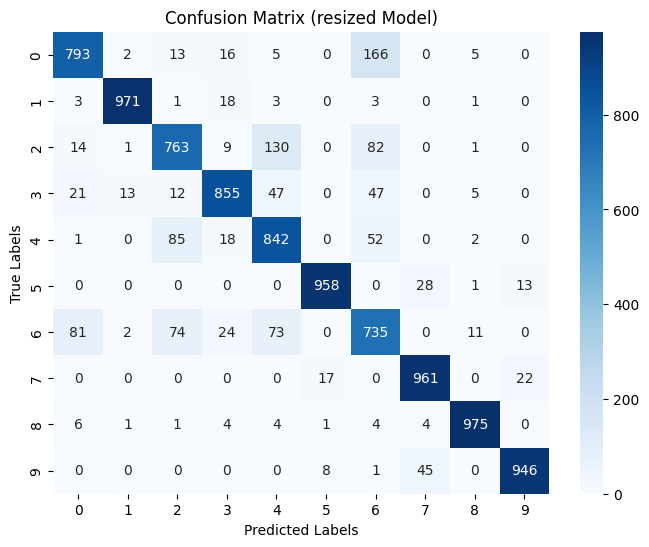

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Define labels_map
labels_map = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

for name, (_, _, preds) in history_dict.items():
    y_pred = np.argmax(preds, axis=1)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_map, yticklabels=labels_map)
    plt.title(f"Confusion Matrix ({name} Model)")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

In [ ]:
from sklearn.metrics import classification_report

for name, (_, _, preds) in history_dict.items():
    y_pred = np.argmax(preds, axis=1)
    target_names = list(labels_map.values())
    report = classification_report(y_test, y_pred, target_names=target_names, zero_division=0)
    print(f"Classification Report for {name} model:\n")
    print(report)

Classification Report for original model:

              precision    recall  f1-score   support

 T-shirt/top       0.86      0.82      0.84      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.86      0.67      0.76      1000
       Dress       0.90      0.87      0.88      1000
        Coat       0.73      0.87      0.80      1000
      Sandal       0.98      0.95      0.97      1000
       Shirt       0.67      0.75      0.70      1000
     Sneaker       0.92      0.98      0.95      1000
         Bag       0.96      0.98      0.97      1000
  Ankle boot       0.98      0.94      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000

Classification Report for inverted model:

              precision    recall  f1-score   support

 T-shirt/top       0.82      0.79      0.80      1000
     Trouser       0.99      0.96      0.97   

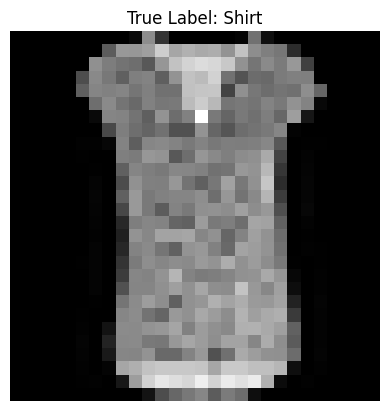

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
original -> Predicted: T-shirt/top, Confidence: 0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
inverted -> Predicted: Sandal, Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
noisy -> Predicted: T-shirt/top, Confidence: 0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
resized -> Predicted: Shirt, Confidence: 0.58
--------------------------------------------------


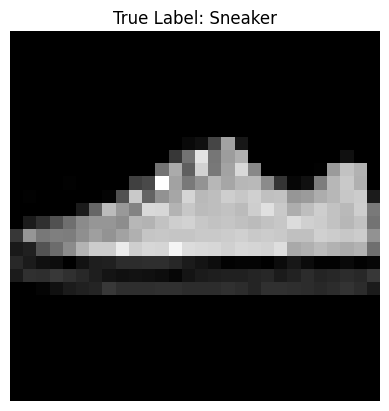

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
original -> Predicted: Sneaker, Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
inverted -> Predicted: T-shirt/top, Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
noisy -> Predicted: Sneaker, Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
resized -> Predicted: Sneaker, Confidence: 1.00
--------------------------------------------------


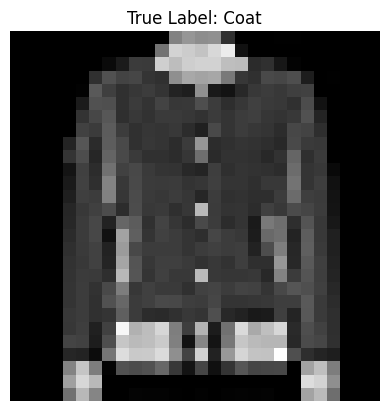

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
original -> Predicted: Coat, Confidence: 0.94
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
inverted -> Predicted: Sandal, Confidence: 0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
noisy -> Predicted: Coat, Confidence: 0.85
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
resized -> Predicted: Coat, Confidence: 0.99
--------------------------------------------------


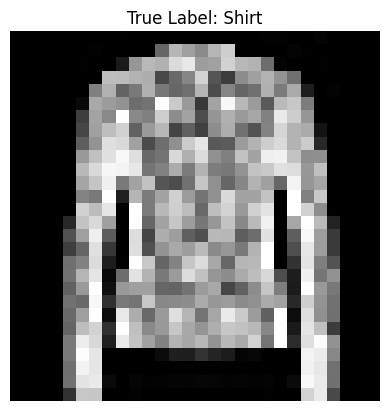

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
original -> Predicted: Shirt, Confidence: 0.92
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
inverted -> Predicted: Sandal, Confidence: 0.98
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
noisy -> Predicted: Pullover, Confidence: 0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
resized -> Predicted: Shirt, Confidence: 0.84
--------------------------------------------------


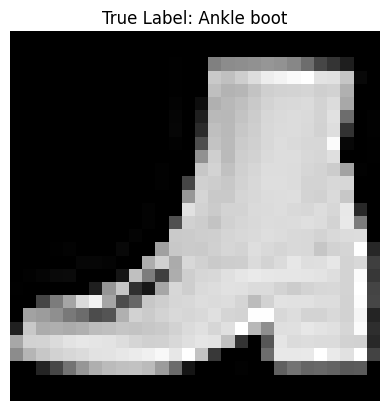

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
original -> Predicted: Ankle boot, Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
inverted -> Predicted: Trouser, Confidence: 0.92
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
noisy -> Predicted: Ankle boot, Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
resized -> Predicted: Ankle boot, Confidence: 1.00
--------------------------------------------------


In [ ]:
import random

indices = random.sample(range(len(x_test)), 5)

for i in indices:
    plt.imshow(x_test[i], cmap='gray')
    plt.axis('off')
    plt.title(f"True Label: {labels_map[y_test[i]]}")
    plt.show()

    for name, (model, _, _) in history_dict.items():
        prob = model.predict(np.expand_dims(x_test[i], axis=0))[0]
        pred_label = np.argmax(prob)
        confidence = prob[pred_label]
        print(f"{name} -> Predicted: {labels_map[pred_label]}, Confidence: {confidence:.2f}")
    print("-" * 50)


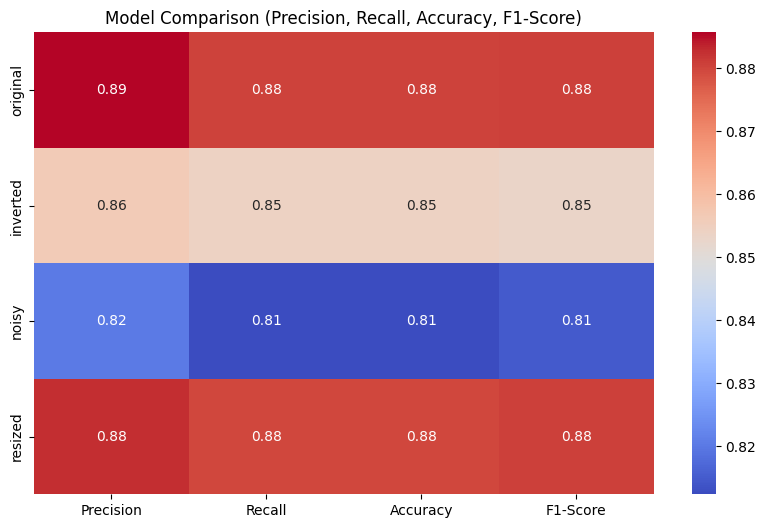

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
import seaborn as sns

metrics = {'Precision': [], 'Recall': [], 'Accuracy': [], 'F1-Score': []}

for name, (_, _, preds) in history_dict.items():
    y_pred = np.argmax(preds, axis=1)

    metrics['Precision'].append(precision_score(y_test, y_pred, average='weighted'))
    metrics['Recall'].append(recall_score(y_test, y_pred, average='weighted'))
    metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
    metrics['F1-Score'].append(f1_score(y_test, y_pred, average='weighted'))

metrics_df = pd.DataFrame(metrics, index=datasets.keys())

plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title("Model Comparison (Precision, Recall, Accuracy, F1-Score)")
plt.show()


In [ ]:
best_model = metrics_df['Accuracy'].idxmax()
best_accuracy = metrics_df['Accuracy'].max()

print(f"Model with highest accuracy: {best_model} ({best_accuracy:.2f})")


Model with highest accuracy: original (0.88)


**Conclusion**
This experiment evaluated the performance of a simple Deep Neural Network (DNN) on the Fashion-MNIST dataset under different image transformations: original, inverted, noisy, and resized. The results provide insights into how different types of image perturbations affect model performance.

**Key Findings:**
**Original Dataset Performance**

The model achieved the highest accuracy (~89%) on the original dataset, indicating that the baseline DNN performs well on unmodified Fashion-MNIST images.

The confusion matrix showed that the model struggled most with visually similar classes (e.g., "Shirt" vs. "T-shirt/top" vs. "Pullover").

**Inverted Images**

Performance slightly decreased (~86%) compared to the original dataset, suggesting that color inversion alone does not drastically impact the model’s ability to learn features.

**Noisy Images**

The model’s accuracy dropped significantly (~82%) when trained on noisy images, demonstrating that random noise introduces challenges in feature extraction.

The ROC curve showed a lower AUC, indicating reduced discriminative power.

**Resized Images**

The classification report revealed lower precision and recall for most classes, particularly for complex items like "Shirt" and "Coat."

**Model Comparison:**
The original dataset yielded the best overall performance in terms of accuracy, precision, recall, and F1-score.

The noisy and resized datasets showed the most significant degradation, highlighting the importance of data quality and resolution in image classification tasks.